<a href="https://colab.research.google.com/github/renanalencar/projeto-cnn-squeezenet/blob/main/Projeto_CNN_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Redes Neurais 

## Referências: 



1. [Estudo sobre Câncer de Cólon utilizando a mesma base com modelod e CNN](https://www.kaggle.com/aayushrajput/lung-colon-cancer)
2. [Modelo de SqueezeNet para reconhecimento de comida](https://www.kaggle.com/kmader/food-squeezenet) 
3. [SqueezeNet no Keras](https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet#6)
4. [Entendendo Redes Convolucionais (CNNs) ](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184#:~:text=H%C3%A1%20muitas%20fun%C3%A7%C3%B5es%2C%20como%20sigmoid,quando%20comparada%20a%20outras%20fun%C3%A7%C3%B5es)
5. [Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)
6. [Tutorial prático do Keras](https://cv-tricks.com/tensorflow-tutorial/keras/)
7. [Métricas de avaliação de modelo](https://gabrielschade.github.io/2019/03/12/ml-classificacao-metricas.html)


## Kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
# Choose the kaggle.json file that you downloaded 
files.upload()
! mkdir ~/.kaggle
# Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json
# That's all! You can check if everything's okay by running this command.
! kaggle datasets list
# Download Data
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
# Use unzip command to unzip the data:
# For example, Create a directory named train, ! mkdir train unzip train data there.
! mkdir input
# unzip train data there,
! unzip lung-and-colon-cancer-histopathological-images.zip -d input

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: input/lung

## Erro na biblioteca keras_applications e pycm

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 51kB 3.1MB/s 


In [ ]:
!pip install pycm

     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 573kB 6.2MB/s 


## Importanto as bibliotecas necessárias

In [ ]:
import h5py
import numpy as np

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine.topology import get_source_inputs
from keras.models import Model, model_from_json
from keras.layers import Dense,Flatten
from keras.layers import Input, Activation, concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Dense,Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.utils import layer_utils
from sklearn.metrics import f1_score,recall_score, precision_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('error')
from pycm import *
   
# from visual_callbacks import AccLossPlotter

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%matplotlib inline

Mounted at /content/drive


## Pré-processamento

O conjunto de dados contém 15.000 imagens coloridas em 3 classes, com 5.000 imagens em cada classe. O conjunto de dados é dividido em 12.000 imagens de treinamento e 3.000 imagens de teste. 

### Variáveis 

In [ ]:
base_dir = '/content/drive/Shareddrives/REDES_NEURAIS_ENG74317/projeto_cnn_squeezenet/' # Diretório dos arquivos 
data_dir = '/content/drive/Shareddrives/REDES_NEURAIS_ENG74317/projeto_cnn_squeezenet/input/lung_image_sets/' # Diretório das imagems 
width, height, nb_class = 768, 768, 3 # Dimensões da entrada
batch_size = 4 # Tamanho do lote para treinamento
shuffle = True # Sortear as amostras 
seed = 42 # Número de sementes 
nb_epoch = 15 # Número de épocas 
loss='categorical_crossentropy' # Algoritmo de optmização das Redes Convolucionais
optimizer_cnn='adam' # Algoritmo de optmização das Redes Convolucionais
optimizer_sn = 'sgd' # Algoritmo de optmização da SqueezeNet
metrics='accuracy' # Métrica utilizada 
target_size = (width, height)
input_shape =  (width, height, nb_class)

### Pré-processamento das imagens 

In [ ]:
def PreProcess(data_dir,target_size,batch_size,shuffle,seed):
    
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

    train_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='training',
                                          seed = seed)

    validation_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)

    return train_cnn, validation_cnn 

## CNN

A saída de cada camada Conv2D e MaxPooling2D é um tensor 3D de forma (altura, largura, canais). As dimensões de altura e largura tendem a diminuir à medida que você se aprofunda na rede. O número de canais de saída para cada camada Conv2D é controlado pelo primeiro argumento (por exemplo, 32 ou 64). Normalmente, à medida que a largura e a altura diminuem, você pode (computacionalmente) adicionar mais canais de saída em cada camada Conv2D.

### Modelo de CNN 

As linhas de código abaixo definir a base convolucional utilizando um padrão comum: uma pilha de Conv2D e MaxPooling2D camadas.

Como entrada, um CNN assume tensores de forma (image_height, image_width, color_channels), ignorando o tamanho do lote. O color_channels se refere a (R, G, B). A CNN foi configuradapara processar entradas de forma (768, 768, 3), que é o formato de imagens lung_image_sets. 

In [ ]:
def Model_CNN():
  model = models.Sequential()

  # BatchNormalization()(inp) testar o BatchNormalization
  # Block 1
  model.add(layers.BatchNormalization(input_shape=(768, 768, 3)))
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(768, 768, 3))) # Original
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1'))
  model.add(layers.Conv2D(32, (1, 1), activation='relu',name='block1_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block1_pool'))

  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', name='block2_conv1'))
  model.add(layers.Conv2D(64, (1, 1), activation='relu',name='block2_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block2_pool'))

  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu',name='block3_conv1'))
  model.add(layers.Conv2D(128, (1, 1), activation='relu',name='block3_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block3_pool'))

  # Block 4
  model.add(layers.Conv2D(256, (3, 3), activation='relu',name='block4_conv1'))
  model.add(layers.Conv2D(256, (1, 1), activation='relu',name='block4_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block4_pool'))

  # Block 5
  model.add(layers.Conv2D(512, (3, 3), activation='relu',name='block5_conv1'))
  model.add(layers.Conv2D(512, (1, 1), activation='relu',name='block5_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block5_pool'))

  # Flatten
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
  
  return model

As (768, 768, 64) saídas serão achatadas em vetores de forma (387) antes de passar por duas camadas densas.

Para completar o modelo, o último tensor de saída da base convolucional (de formato (4, 4, 64)) em uma ou mais camadas Densas para realizar a classificação. Camadas densas recebem vetores como entrada (que são 1D), enquanto a saída atual é um tensor 3D. Primeiro, você nivelará (ou desenrolará) a saída 3D em 1D e, em seguida, adicionará uma ou mais camadas Densas na parte superior. O conjunto tem 3 classes de saída, então você usa uma camada Densa final com 3 saídas.

### Função para compilar o modelo da CNN

In [ ]:
def Compile_Model_CNN(loss, optimizer_cnn, metrics):
  model_cnn = Model_CNN()
  sgd = SGD(lr=0.001, decay=0.0002, momentum=0.9, nesterov=True)
  opt = RMSprop(lr=0.0001, decay=1e-6)
  model_cnn.compile(loss=loss, optimizer=opt, metrics=metrics)
  model_cnn.summary()
  return model_cnn

### Função de treinamento da CNN

In [ ]:
def Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn):
    history_cnn = model_cnn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_cnn.to_json()
    model_name = "Modelo_CNN"
    with open(base_dir+'models/'+model_name+".json", "w") as json_file:
        json_file.write(model_json)
    model_cnn.save_weights(base_dir+'weights/'+model_name+'.h5')
    
    return history_cnn

### Função para execução da CNN

In [ ]:
def Execute_Model_CNN():
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_cnn = Compile_Model_CNN(loss, optimizer_cnn, metrics)

    history_cnn = Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn)
    
    # Plotar a curva de aprendizagem
    history_dict = history_cnn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(base_dir+'graphs/Curva_de_aprendizagem_CNN.png')
  

### Função para avaliação  da CNN

In [ ]:
def Evaluate_Model_CNN():

    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    test_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)
    
    # train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open(base_dir+'models/Modelo_CNN.json','r') as modelo:
      json = modelo.read()
    model_cnn = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_cnn.load_weights(base_dir+'weights/Modelo_CNN.h5') 

    Y_pred = model_cnn.predict(test_cnn)
    y_pred = np.argmax(Y_pred, axis=1)

    
    cm = ConfusionMatrix(actual_vector=test_cnn.classes, predict_vector=y_pred)
    
    print('                 Aca\tN\tSCC')
    print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]))    
    print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]))

    # guardar o resultado das métricas
    model_name = "Modelo_CNN"
    with open(base_dir+'results/'+model_name+'.txt', 'w') as arquivo:
      print('                 Aca\tN\tSCC', file=arquivo)
      print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]), file=arquivo)    
      print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]), file=arquivo)

    cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(test_cnn.classes, Y_pred[:,i], pos_label=i)

    plt.figure()
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(base_dir+'graphs/Multiclass_ROC_CNN.png',dpi=300); 

### Chamada para execução da CNN

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 768, 768, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 32)      1056      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 32)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 382, 382, 64)      18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 382, 382, 64)      4160      
___________________________________

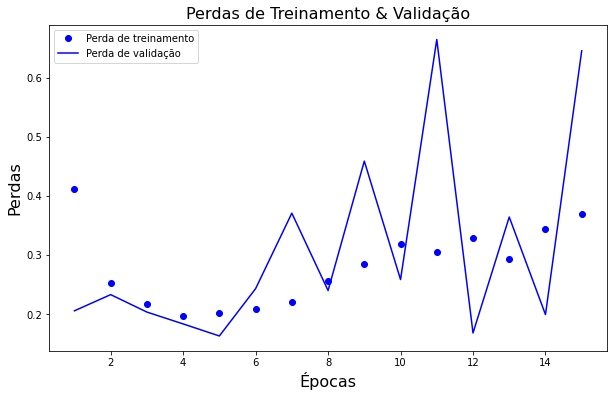

In [ ]:
Execute_Model_CNN()

### Chamada para avaliação da CNN




In [ ]:
Evaluate_Model_CNN()